In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from safetensors.torch import save_model, load_model


In [2]:
batch_size = 256
figsize = 16

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((2, 2, 2, 2)),
    transforms.Normalize((.0,), (1.0,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


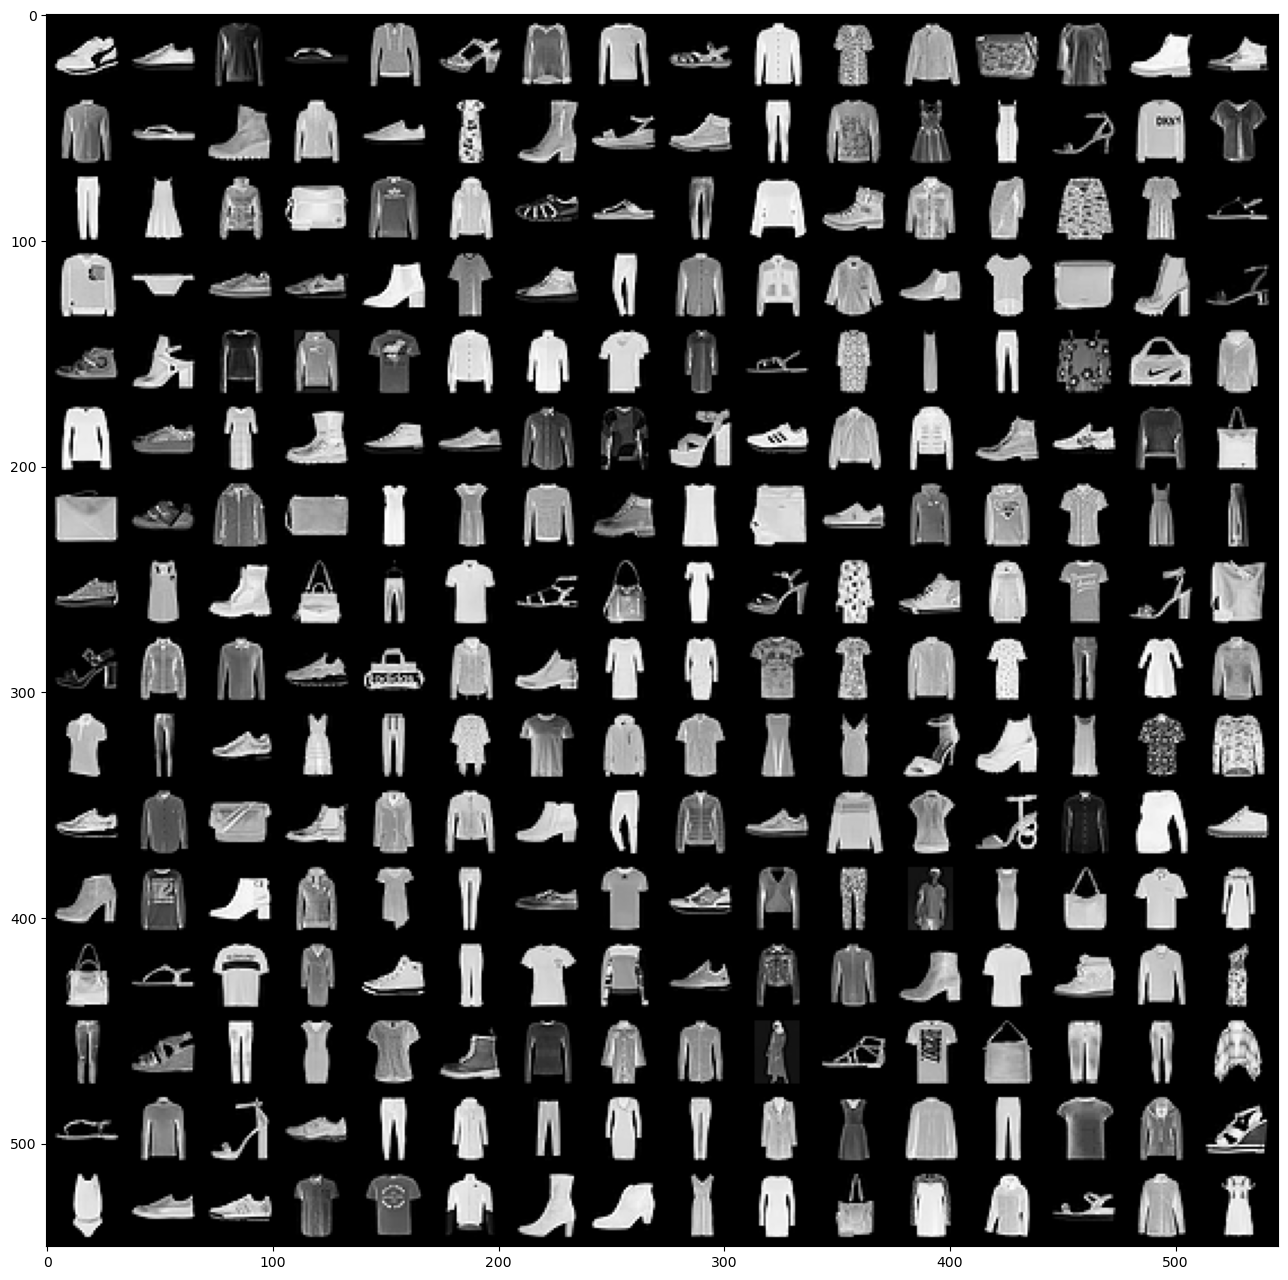

In [4]:
# Function to show an image
def imshow(img):
    plt.figure(figsize=(figsize,figsize))
    plt.imshow(img.cpu().permute(1, 2, 0).numpy())
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images, nrow=16))

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.relu3 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 4 * 4, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [6]:
encoder = Encoder().cuda()
summary(encoder, (batch_size, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [256, 2]                  --
├─Conv2d: 1-1                            [256, 32, 16, 16]         320
├─ReLU: 1-2                              [256, 32, 16, 16]         --
├─Conv2d: 1-3                            [256, 64, 8, 8]           18,496
├─ReLU: 1-4                              [256, 64, 8, 8]           --
├─Conv2d: 1-5                            [256, 128, 4, 4]          73,856
├─ReLU: 1-6                              [256, 128, 4, 4]          --
├─Flatten: 1-7                           [256, 2048]               --
├─Linear: 1-8                            [256, 2]                  4,098
Total params: 96,770
Trainable params: 96,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 627.57
Input size (MB): 1.05
Forward/backward pass size (MB): 29.36
Params size (MB): 0.39
Estimated Total Size (MB): 30.80

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()        
        self.fc = nn.Linear(2, 2048)
        self.unflatten = nn.Unflatten(1, (128, 4, 4))
        self.convt1 = nn.ConvTranspose2d(128, 128, 3, 2, 1, 1)
        self.relu1 = nn.ReLU()
        self.convt2 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.relu2 = nn.ReLU()
        self.convt3 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.relu3 = nn.ReLU()
        self.conv = nn.Conv2d(32, 1, 3, 1, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)
        x = self.convt1(x)
        x = self.relu1(x)
        x = self.convt2(x)
        x = self.relu2(x)
        x = self.convt3(x)
        x = self.relu3(x)
        x = self.conv(x)
        x = self.sigmoid(x)
        return x

In [8]:
decoder = Decoder().cuda()
summary(decoder, (batch_size, 2))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [256, 1, 32, 32]          --
├─Linear: 1-1                            [256, 2048]               6,144
├─Unflatten: 1-2                         [256, 128, 4, 4]          --
├─ConvTranspose2d: 1-3                   [256, 128, 8, 8]          147,584
├─ReLU: 1-4                              [256, 128, 8, 8]          --
├─ConvTranspose2d: 1-5                   [256, 64, 16, 16]         73,792
├─ReLU: 1-6                              [256, 64, 16, 16]         --
├─ConvTranspose2d: 1-7                   [256, 32, 32, 32]         18,464
├─ReLU: 1-8                              [256, 32, 32, 32]         --
├─Conv2d: 1-9                            [256, 1, 32, 32]          289
├─Sigmoid: 1-10                          [256, 1, 32, 32]          --
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 12.17
Input size (MB): 0.00
For

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [10]:
model = Autoencoder().cuda()
summary(model, (batch_size, 1, 32, 32))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
num_epochs = 3

for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()  
        output = model(imgs)
        loss = criterion(output, imgs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/3], Loss: 0.3653
Epoch [2/3], Loss: 0.2960
Epoch [3/3], Loss: 0.2871


In [12]:
save_model(model, "data/autoencoder.safetensors")

In [13]:
model = Autoencoder().cuda()

In [14]:
load_model(model, "data/autoencoder.safetensors")

(set(), [])

In [15]:
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
test_x, test_label = next(iter(test_loader))
test_x = test_x.cuda()
test_y = model(test_x)

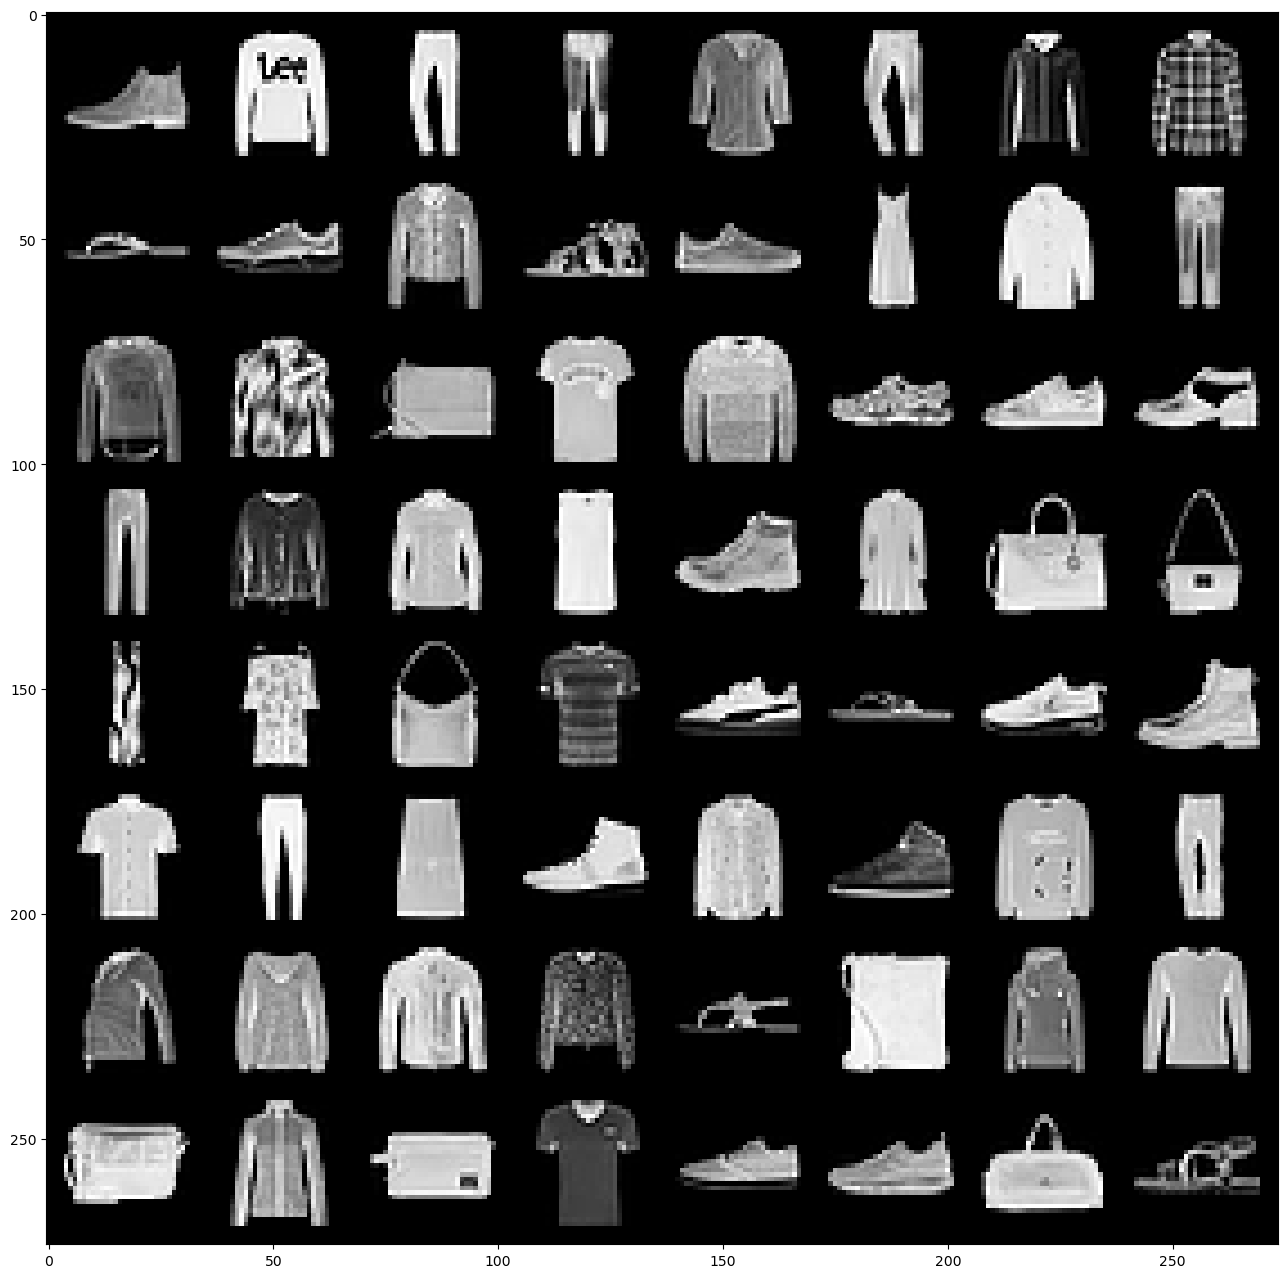

In [16]:
imshow(torchvision.utils.make_grid(test_x[:64]))

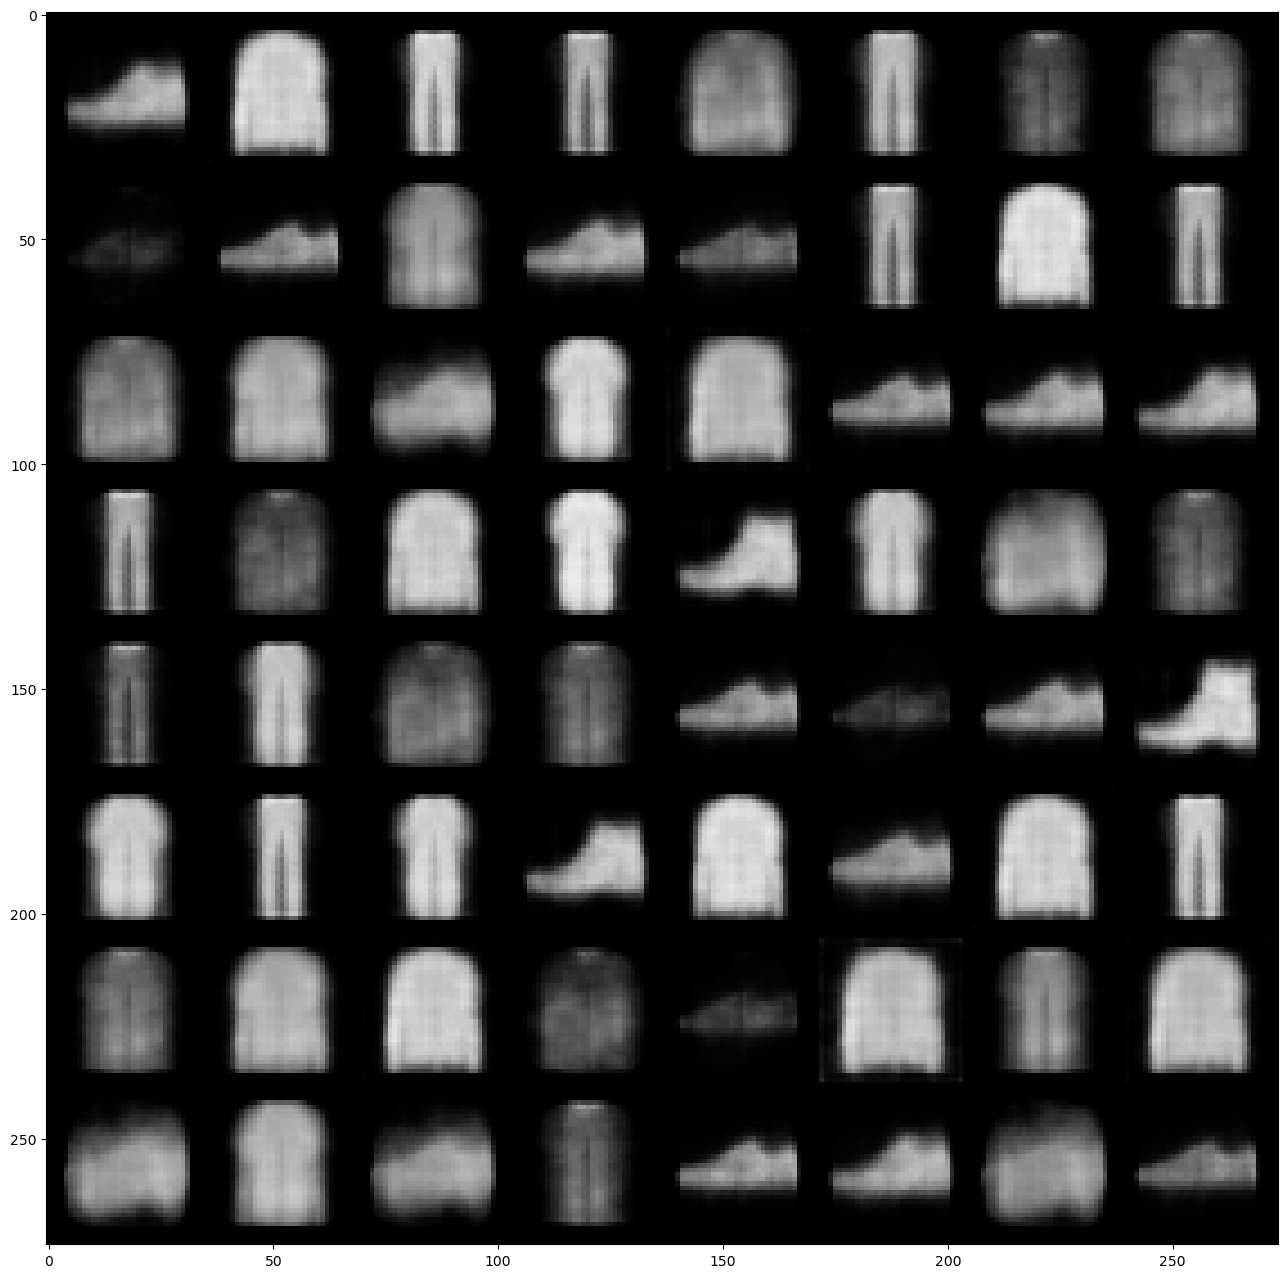

In [17]:
imshow(torchvision.utils.make_grid(test_y[:64]))

In [18]:
with torch.no_grad():
    embeddings = model.encoder(test_x).cpu()

In [19]:
print(embeddings[:10])

tensor([[-17.2888,  -6.6911],
        [  0.8487,  -6.5581],
        [-10.3665, -26.1405],
        [-13.2796, -26.8712],
        [ -5.1009,  -5.8143],
        [ -8.8913, -20.4440],
        [-12.1354, -15.7713],
        [ -7.2028,  -9.7398],
        [-24.9408, -21.2782],
        [-22.6086, -12.5264]])


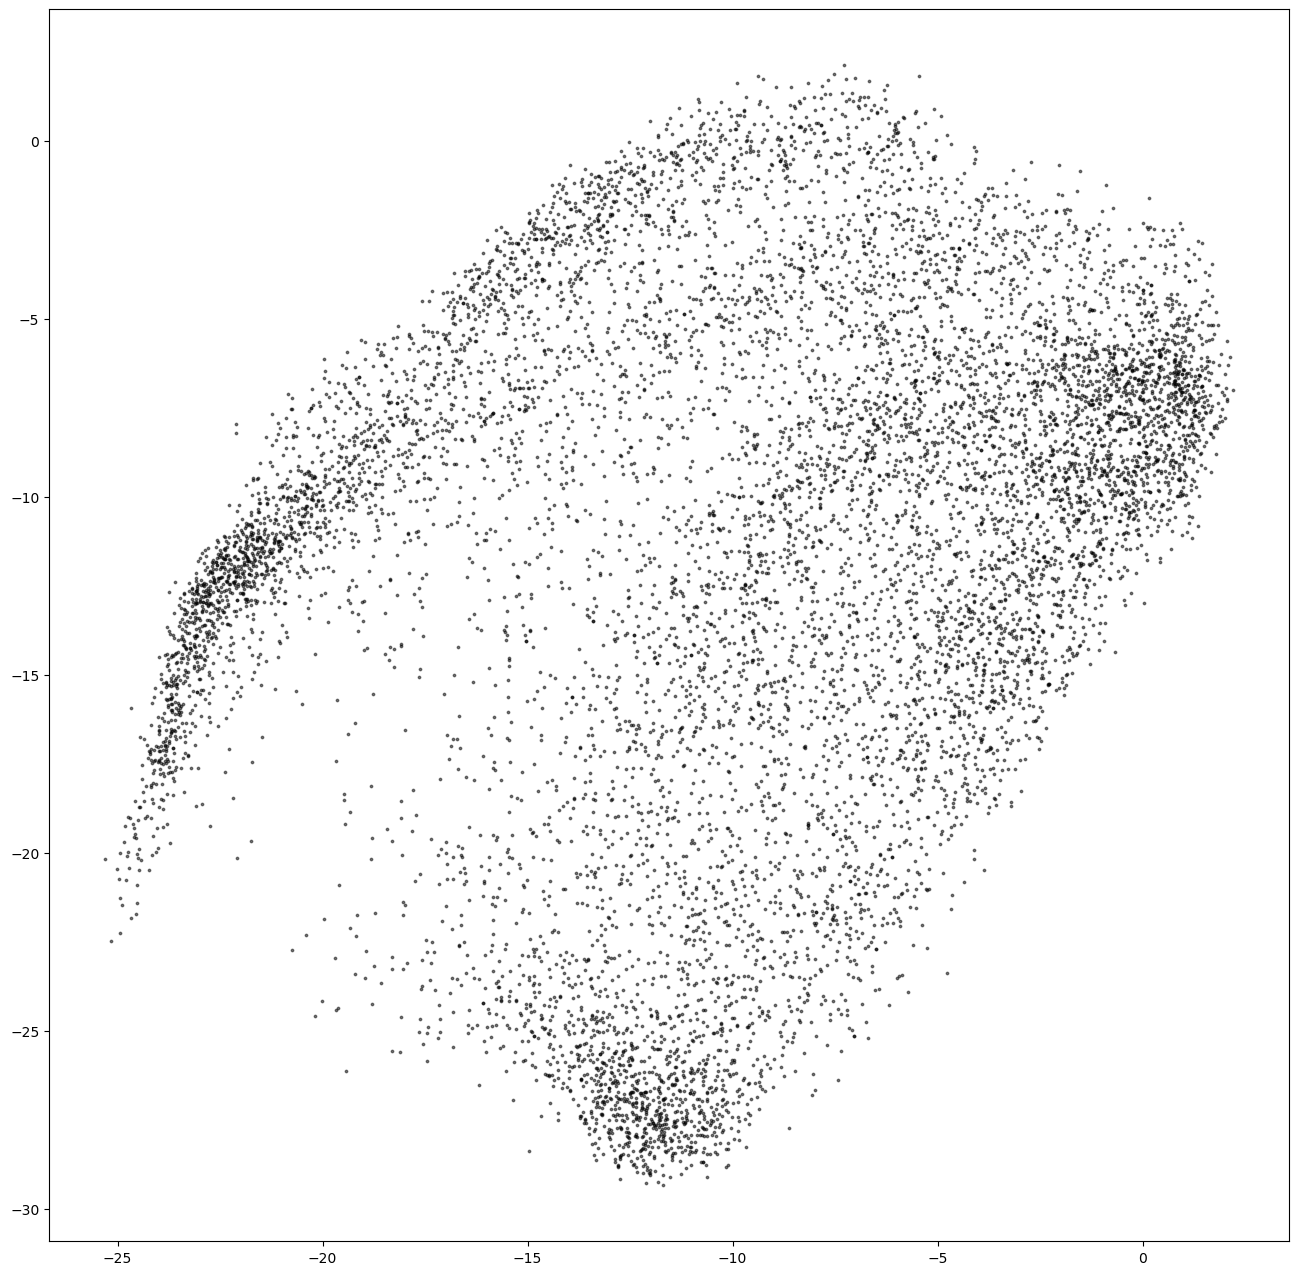

In [20]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

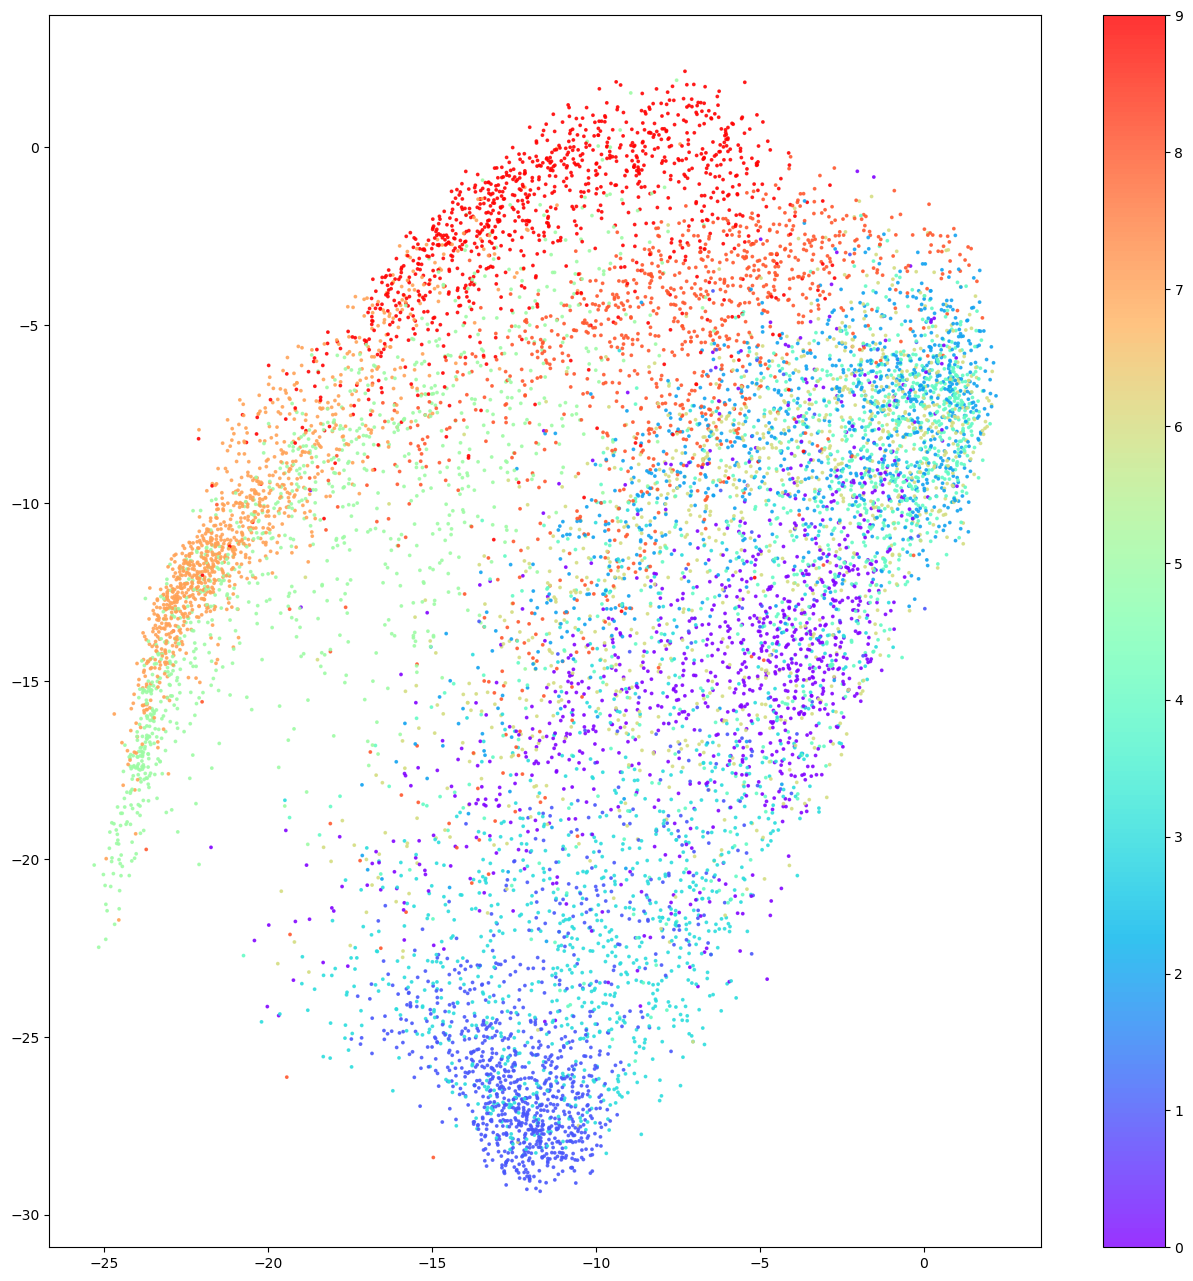

In [21]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=test_label,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [22]:
mins, _ = torch.min(embeddings, dim=0)
maxs, _ = torch.max(embeddings, dim=0)
mins, maxs

(tensor([-25.2970, -29.3408]), tensor([2.2011, 2.1273]))

In [23]:
grid_width, grid_height = (8, 8)
sample = (maxs - mins) * torch.rand(64, 2) + mins


In [24]:
with torch.no_grad():
    reconstructions = model.decoder(sample.cuda()).cpu()


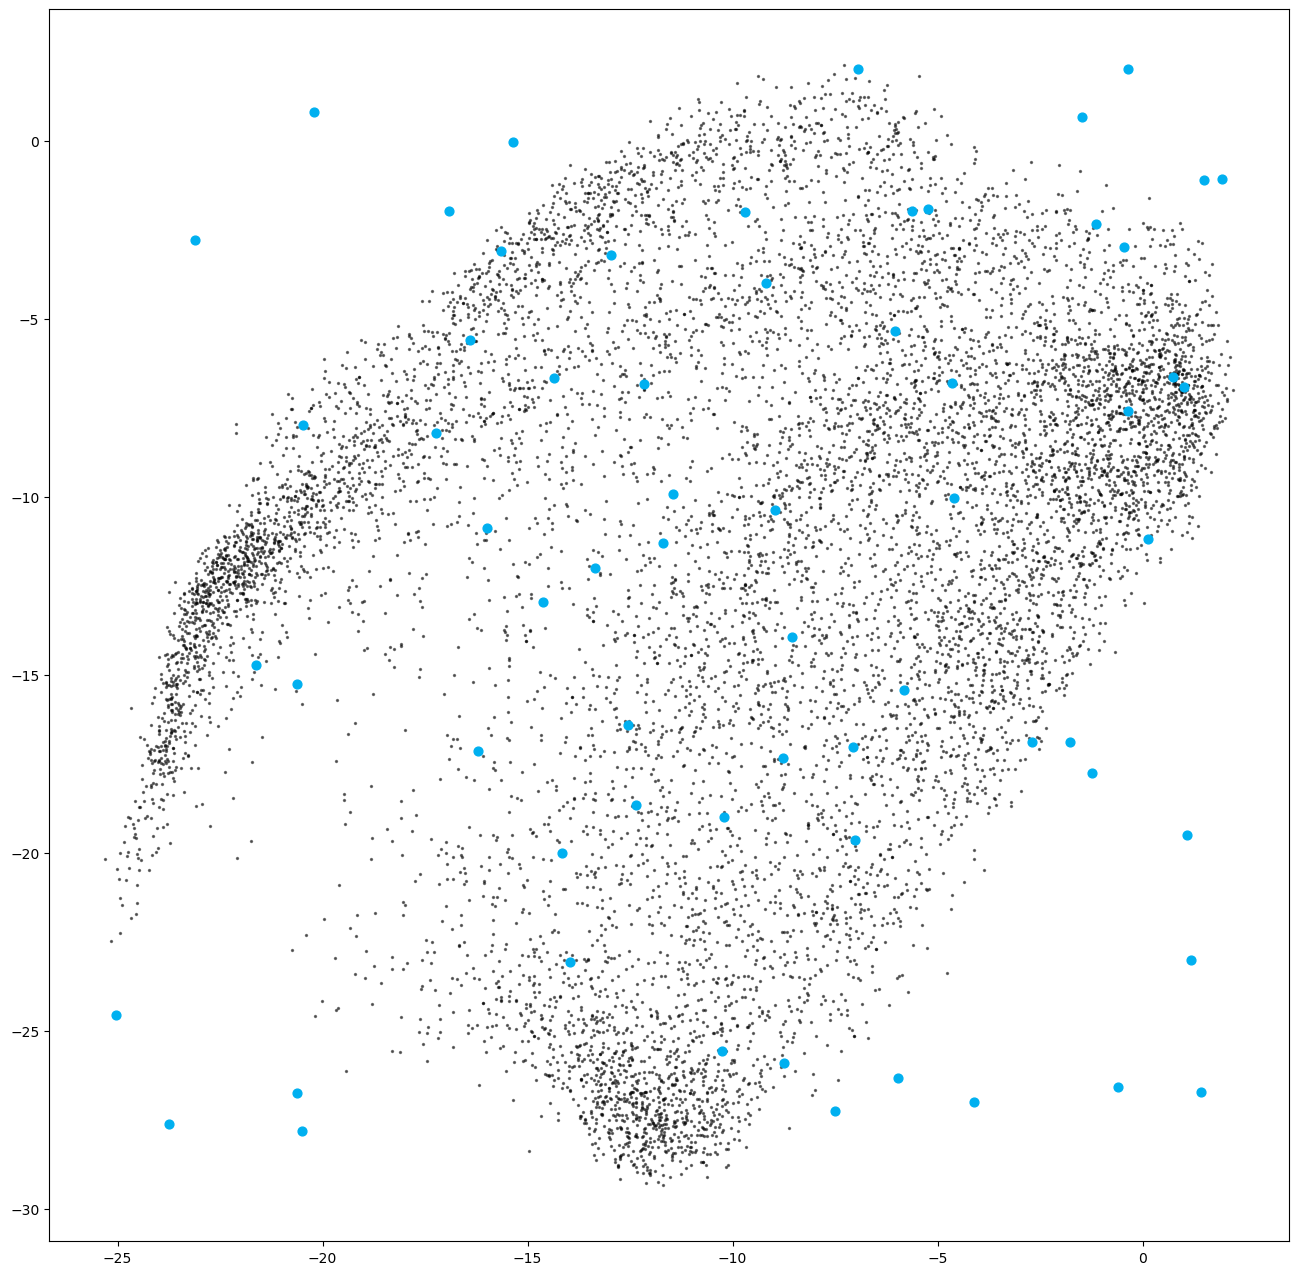

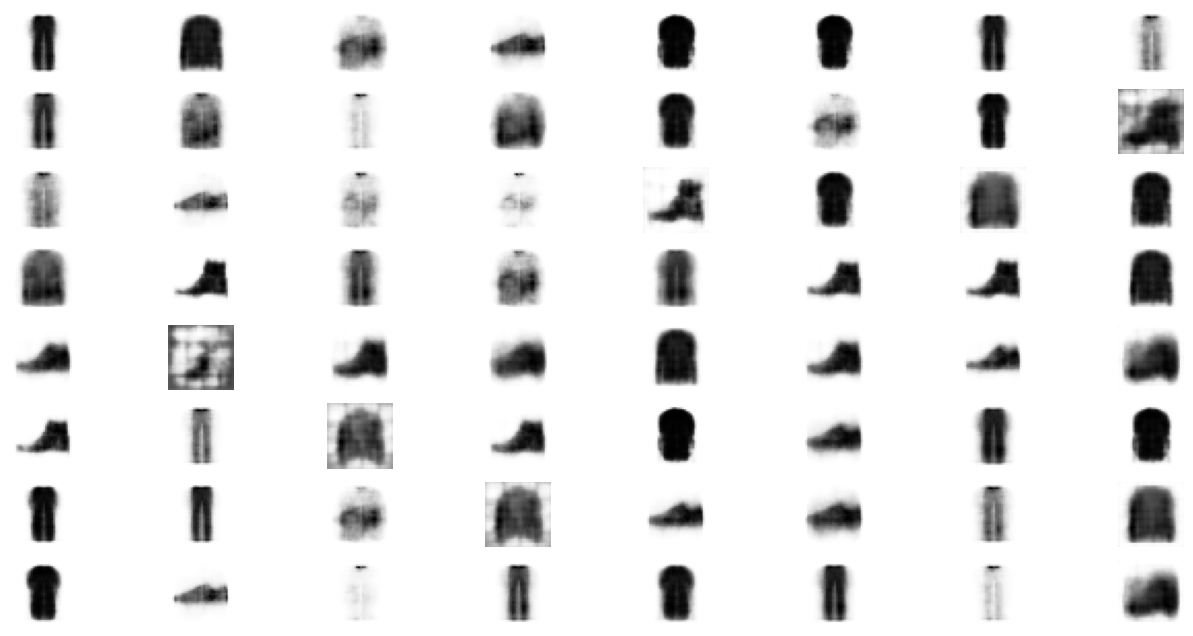

In [25]:
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height))

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i].squeeze(), cmap="Greys")

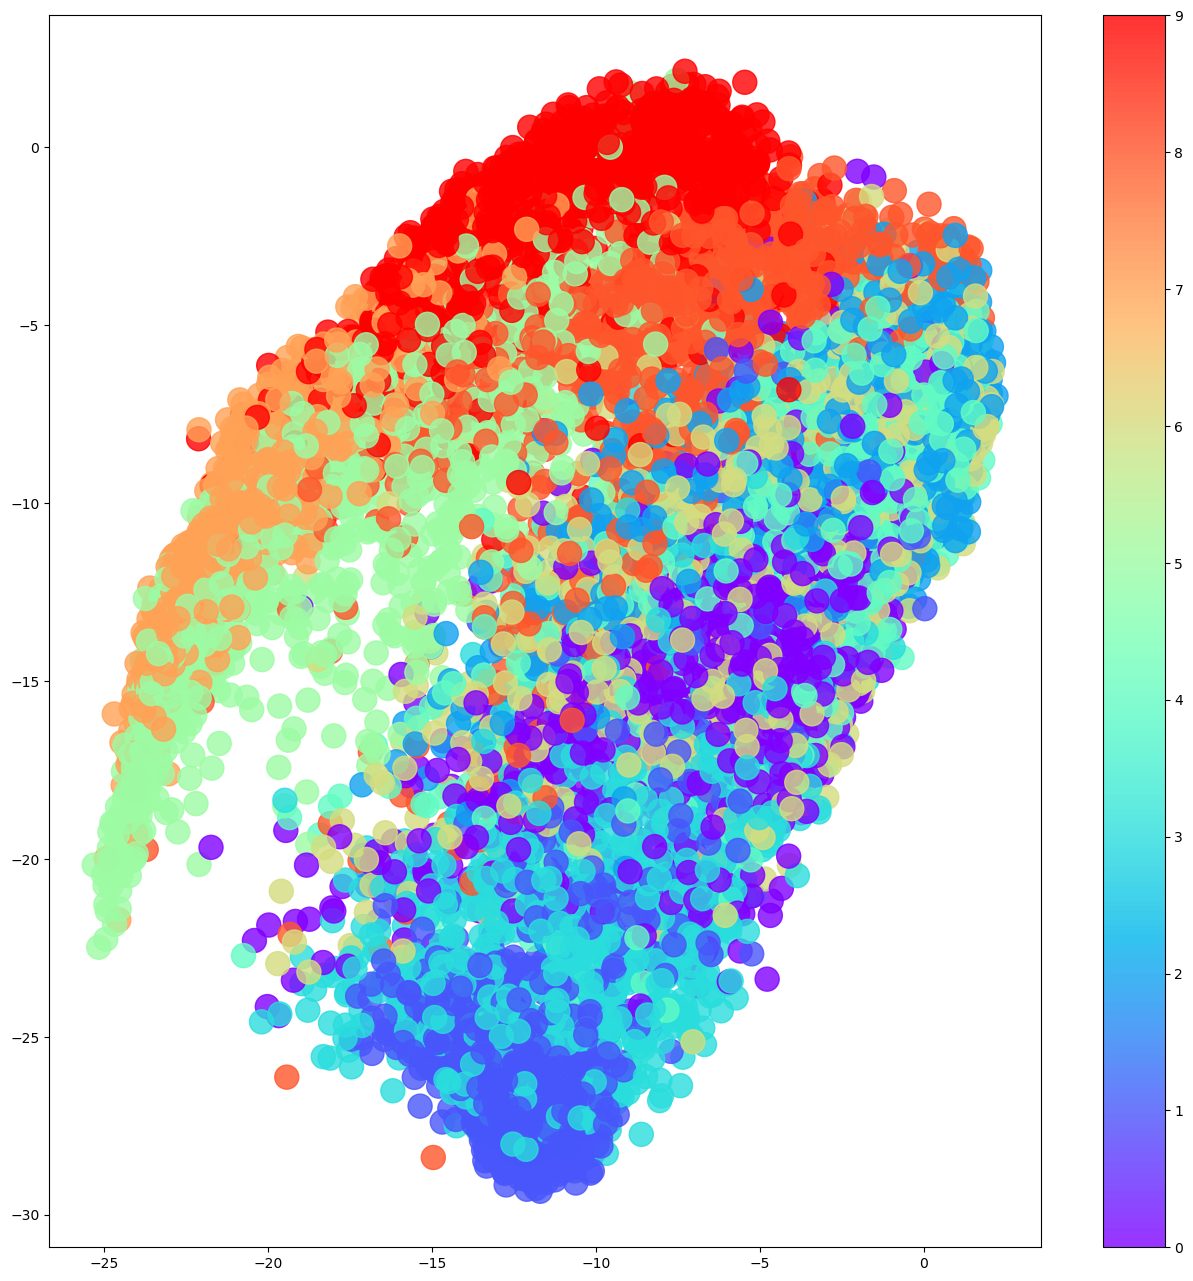

In [26]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=test_label,
    alpha=0.8,
    s=300,
)
plt.colorbar()
plt.show()

In [27]:
grid_size = 16

x = torch.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = torch.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = torch.meshgrid(x, y, indexing='ij')
xv = xv.flatten()
yv = yv.flatten()
grid = torch.stack((xv, yv), dim=1)

In [28]:
with torch.no_grad():
    reconstructions = model.decoder(grid.cuda()).cpu()

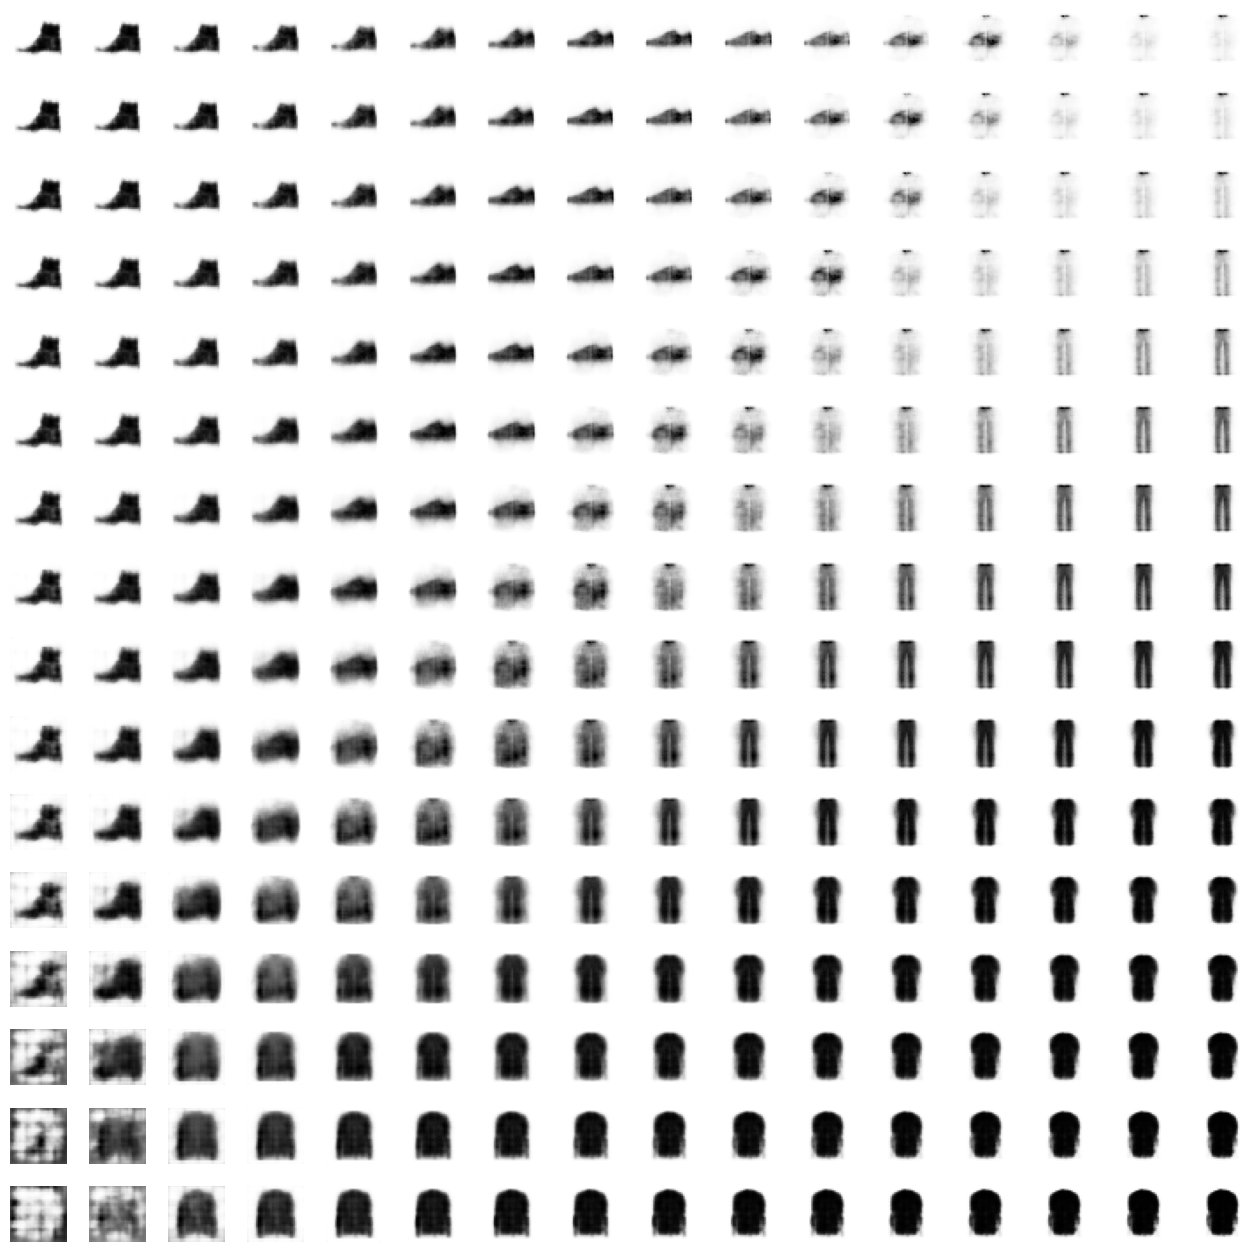

In [29]:
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i].squeeze(), cmap="Greys")